# Test and debug Kalman filter

---

## Equations verified by the simulator

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}

## Equations employed by the Kalman filter

The Kalman state vector is:
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (\gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
#print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-350.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax, vol_max=vmax, vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-50.)

-3248.9 g  were added to the float in order to be at equilibrium at 25 dbar 

Piston vol_min reset from d_min, d_max and vol_max
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.80 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte = m/V = 1.02e+09 kg.cm^3   - float baseline density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 2.50 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 115.47 cm^3      - present volume addition
  d_increment  = 3.65e-02 mm        - smallest variation of translation motion for the piston
  vol_increment  = 7.16e-02 cm^3        - s

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

Piston reset for equilibrium : vol=-1.0e+01 cm^3  
z equilibrium = -1.0m


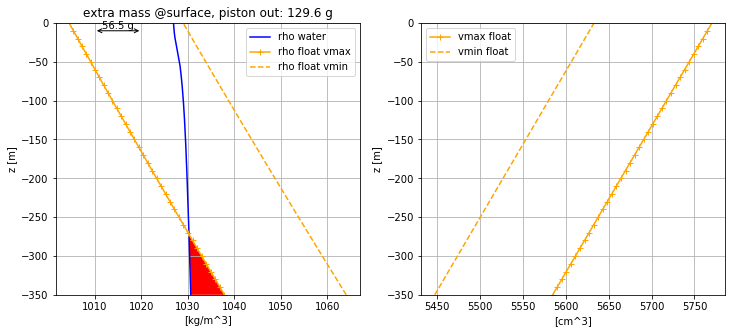

In [5]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [6]:
delta_rho = 5 # change of water density over the depth of interest
L_rho = 100 # characteristic length scale for water density changes

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:

\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


V_e ~ 2.8e-05


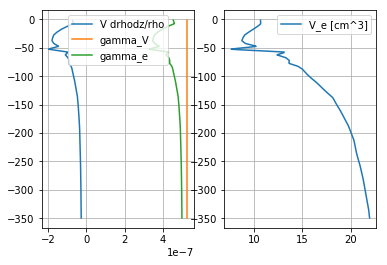

In [7]:
zm = (z[1:]+z[:-1])*.5

V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte

gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)

gamma_e = gamma_rho + gamma_V

V_e25 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e25 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e [cm^3]')
ax.grid()
ax.legend()

print('V_e ~ %.1e' %(f.V*delta_rho/f.rho_cte))

---

### set up desired trajectory

In [8]:
# we start by constructing a trajectory that can be followed by the float
#z_target = fl.descent(3600, -25., f, w, zstart = 0)
z_target = fl.descent(3600, -25., wmax=0.1, zstart = z0)

In [9]:
f0 = deepcopy(f)

---

### regulation

In [10]:
# use PID for control to decouple Kalman filtering from control
tau = 15. # time scale
u = f.piston.u_max/2./2.

_c = {'mode': 'pid', 'dt': 2.,
      'Kp': u, 'Ki': u/tau*1., 'Kd': u*tau*5., 
      'dz_nochattering': 0.}

---

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [11]:
V_e_cst = 1e-5
gamma_e_cst = 0.5*f.gammaV

def _compute_force(z, w, waterp, Lv, v=None):
    g = 9.81
    _f = g * f.rho_cte * (V_e_cst + gamma_e_cst * z + v)
    _f += - f.m * f.c1/2/Lv * np.abs(w) * w
    return _f
f.compute_force = _compute_force

Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [6.67e-04 1.00e-03 5.26e-09 1.00e-07]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  error = 0.0
  integral = 0.0
  mode = pid
  Kp = 1.073786551519949e-06
  Ki = 7.158577010132993e-08
  Kd = 8.053399136399618e-05
Start time stepping for 11 min ...
... time stepping done


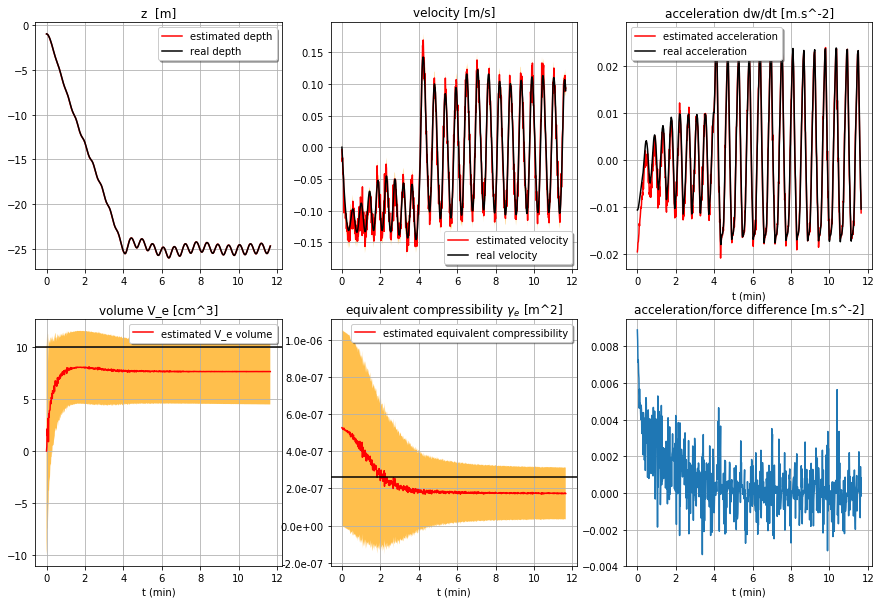

In [12]:
expected_velocity = 0.1
expected_acceleration = expected_velocity/tau*1e1 # value diagnosed a posteriori

# general kalman filter parameters
_k = {'dt':.2, 'depth_error': 1e-2}
# initial state covariance:
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([expected_acceleration, 
                                           expected_velocity,
                                           f.gammaV,
                                           V_e_cst,
                                          ])**2 *1e-4})

f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst)

In the simulation above:

- dynamical errors are small (1% of acceleration, velocity, etc)
 
- errors on $V_e$ and $\gamma_e$ grow with larger depth error and initial errors

- when intial errors are small, convergence is slow

We illustrate next what happens if the depth error is reduced


Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-03 1.00e-03 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [6.67e-04 1.00e-03 5.26e-09 1.00e-07]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  error = 0.0
  integral = 0.0
  mode = pid
  Kp = 1.073786551519949e-06
  Ki = 7.158577010132993e-08
  Kd = 8.053399136399618e-05
Start time stepping for 11 min ...
... time stepping done


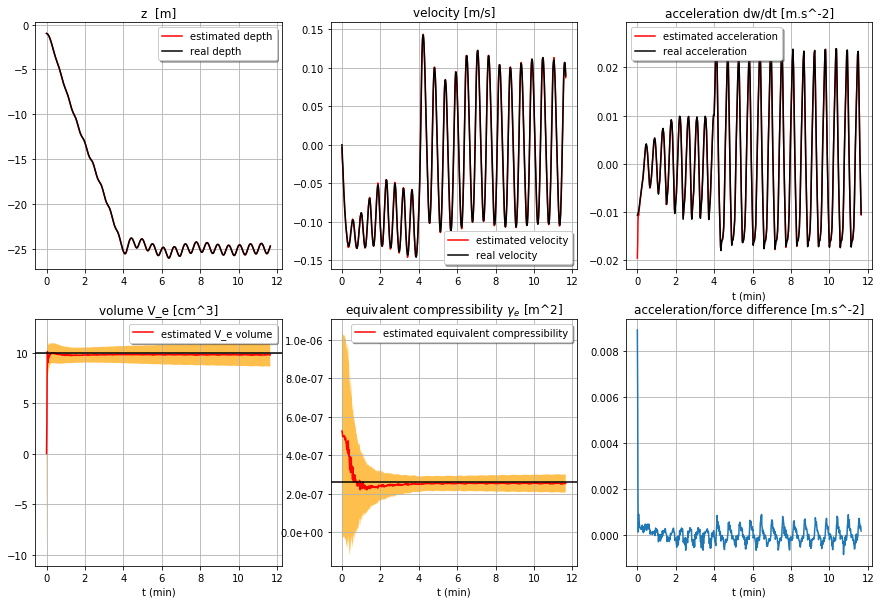

In [13]:
# reduces the depth error:
_k['depth_error'] = 1e-3
# update the initial covariance
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
#
f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst)

We increase the Kalman filter time step next.
There are now oscillations in the kalman filter which we don't know how to explain.

Kalman filter object: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-03 1.00e-03 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [6.67e-04 1.00e-03 5.26e-09 1.00e-07]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  error = 0.0
  integral = 0.0
  mode = pid
  Kp = 1.073786551519949e-06
  Ki = 7.158577010132993e-08
  Kd = 8.053399136399618e-05
Start time stepping for 11 min ...
... time stepping done


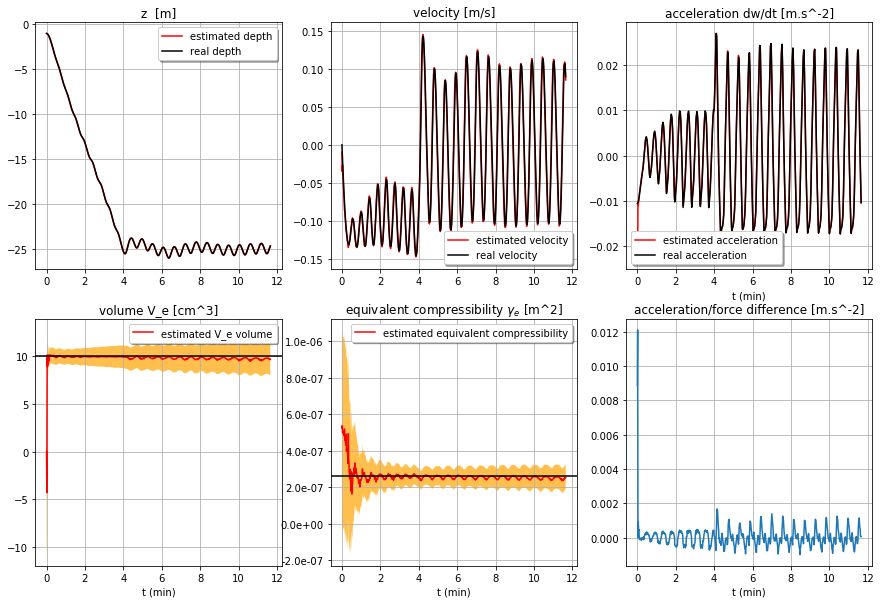

In [14]:
_k['dt'] = .5
# update the initial covariance
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
#
f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst)

---

### Kalman filter with real physics

In [15]:
f = deepcopy(f0)

Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 2.76e-05]
  sqrt(gamma_alpha) / dt: [6.67e-03 1.33e-03 5.26e-09 2.76e-09]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  error = 0.0
  integral = 0.0
  mode = pid
  Kp = 1.073786551519949e-06
  Ki = 7.158577010132993e-08
  Kd = 8.053399136399618e-05
Start time stepping for 11 min ...
... time stepping done


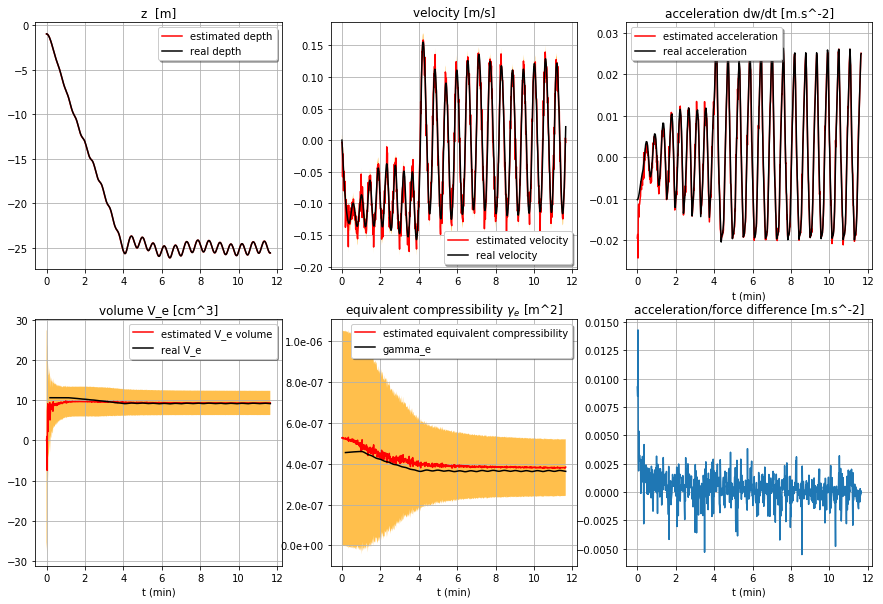

In [16]:
expected_velocity = 0.1
expected_acceleration = expected_velocity/tau*1e1 # value diagnosed a posteriori

_k = {'dt':.2, 'depth_error': 1e-2}

# initial covariance
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2})

# dynamics covariance
_k.update({'gamma_alpha_scaled': np.array([expected_acceleration, 
                                           _k['dt']*expected_acceleration,
                                           expected_velocity*f.gammaV,
                                           expected_velocity*f.V*delta_rho/f.rho_cte/L_rho,
                                           ])**2 *1e-2})

f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

#fl.plot_kalman(f.log, f, V_e = V_e25, gamma_e = gamma_e25)
#
V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z)

**Next**:
    
- verify amplitude of acceleration errors based on approximate

Amplitudes on velocity decrease fairly rapidly to reach values around 2.5 cm/s:

0    0.050741
1    0.030886
2    0.029849
3    0.028203
4    0.026827
Name: gamma_diag0, dtype: float64


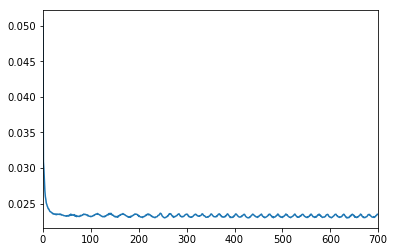

In [17]:
print(np.sqrt(f.log['kalman']._df['gamma_diag0']).head())
np.sqrt(f.log['kalman']._df['gamma_diag0']).plot()

---

### Kalman filter with feedback regulation

Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 2.76e-05]
  sqrt(gamma_alpha) / dt: [6.67e-03 1.33e-03 5.26e-09 2.76e-09]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  tau = 15.0
  nu = 0.03183098861837907
  delta = 0.1
  gamma = 9.3e-05
  m = 5.796134381066166
  a = 1.0
  Lv = 0.5
  c1 = 1.0
  gammaV = 5.259026102109313e-07
  rho_cte = 1024.9815973017373
  mode = feedback
Start time stepping for 11 min ...
... time stepping done


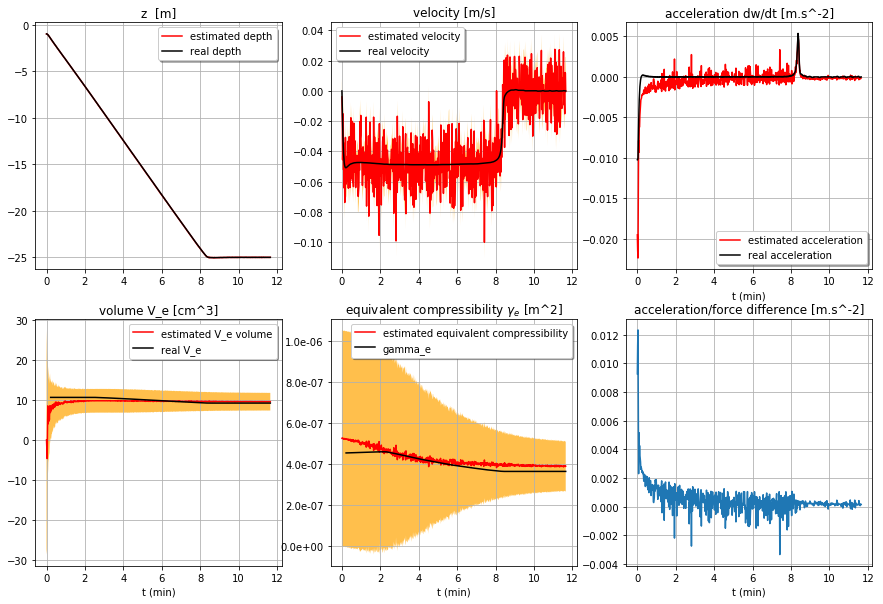

In [18]:
velocity = 0.05
_c = {'mode': 'feedback', 'dt': 2., 'dz_nochattering': 0.,
      'nu': velocity*2./np.pi, 'tau': 15., 'delta': .1, 
     }

f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

#fl.plot_kalman(f.log, f, V_e = V_e25, gamma_e = gamma_e25)
#
V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z)

Extrapolated energy conssumption: 8.5e-04 Wh/day = 0.0 Wh/30day


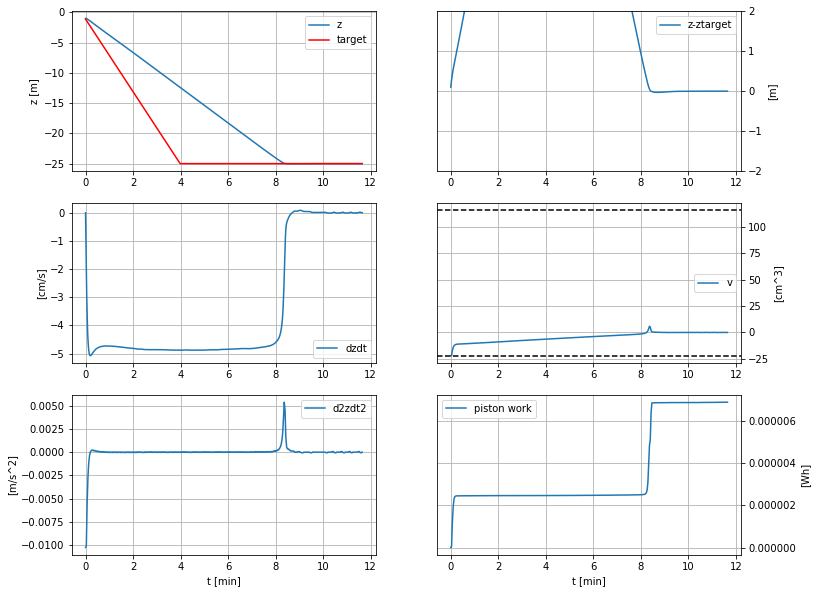

In [19]:
f.plot_logs(z_target=z_target)

Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 2.76e-05]
  sqrt(gamma_alpha) / dt: [6.67e-03 1.33e-03 5.26e-09 2.76e-09]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  tau = 15.0
  nu = 0.03183098861837907
  delta = 0.1
  m = 5.796134381066166
  a = 1.0
  Lv = 0.5
  c1 = 1.0
  gammaV = 5.259026102109313e-07
  rho_cte = 1024.9815973017373
  mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


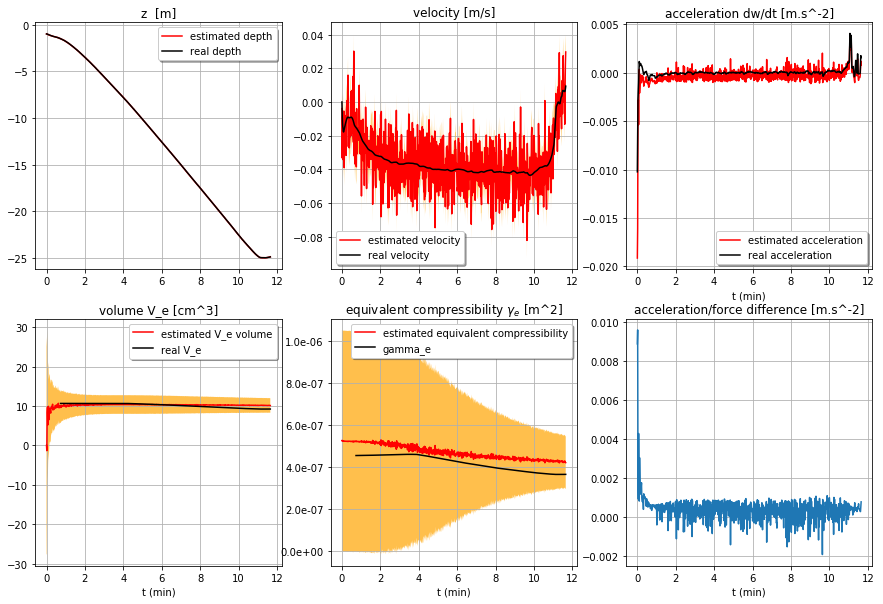

In [20]:
velocity = 0.05
_c = {'mode': 'kalman_feedback', 'dt': 2., 'dz_nochattering': 0.,
      'nu': velocity*2./np.pi, 'tau': 15., 'delta': .1, 
     }

f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z)

Extrapolated energy conssumption: 1.7e-03 Wh/day = 0.1 Wh/30day


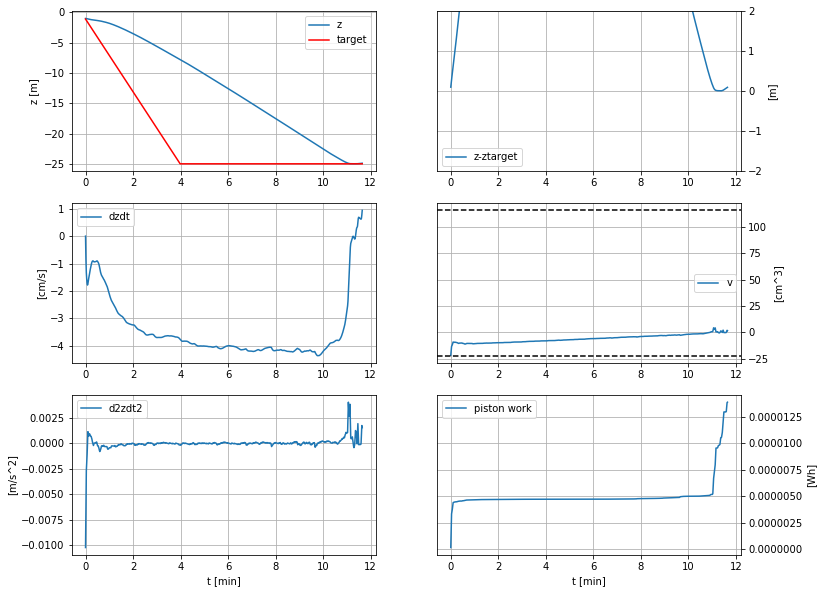

In [21]:
f.plot_logs(z_target=z_target)

In the example above, it turned out to be important to set initial volume to vol_min such as the float start sinking quickly.
If the float touches the surface, it messes up the Kalman filter estimate and the regulation:

Kalman filter object: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 2.76e-05]
  sqrt(gamma_alpha) / dt: [6.67e-03 1.33e-03 5.26e-09 2.76e-09]
Control parameters:
  dt = 2.0
  dz_nochattering = 0.0
  tau = 15.0
  nu = 0.03183098861837907
  delta = 0.1
  m = 5.796134381066166
  a = 1.0
  Lv = 0.5
  c1 = 1.0
  gammaV = 5.259026102109313e-07
  rho_cte = 1024.9815973017373
  mode = kalman_feedback
Start time stepping for 11 min ...
... time stepping done


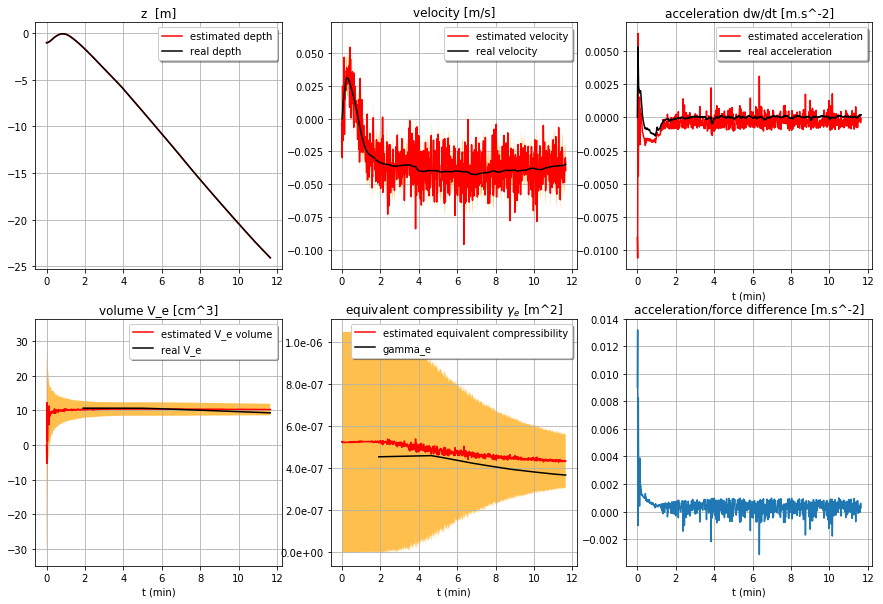

In [24]:
velocity = 0.05
_c = {'mode': 'kalman_feedback', 'dt': 2., 'dz_nochattering': 0.,
      'nu': velocity*2./np.pi, 'tau': 15., 'delta': .1, 
     }

f.time_step(w,T=700., dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z)